# Machine Learning Project: Fraud Detection

The Tunisian Company of Electricity and Gas (STEG) is a public and a non-administrative company, it is responsible for delivering electricity and gas across Tunisia. The company suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers. Using the client’s billing history, our aim is to detect and recognize clients involved in fraudulent activities.

## Data Product

- Goal: detect clients involved in fraudulent activities, separate them from non-fraudulent clients. 
- Value of Product: enhance the company’s revenues by reducing the losses caused by fraudulent activities, avoid reputation damage.
- Evaluation Metric: ROC-AUC (False Positives will be investigated by the company, False Negatives mean monetary loss for the company).
- Baseline Model: coin toss, since no intuitive baseline model gave good results.

## Tested Classifiers

1. KNN: prediction takes too much time because of dataset size.
2. Decision Trees: good performance out-of-the-box, can be fine-tuned with good data-cleaning.
3. Random Forests: slightly worse performance than Decision Trees, computational time okay.
4. Extra Trees: slightly worse performance than Decision Trees, computational time short-
3. K-Means: fast but poor classification performance.
4. LightGBM: fast but poor performance.
5. XGboost: fast but poor performance.
6. Logistic Regression: fast computation, but poor performance.
7. AdaBoost: slow and poor performance.
8. SVM: very slow.
9. Naive Bayes Classifier: fast but poor performance.


## Setup

In [10]:
import pandas as pd
import numpy as np
import warnings
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, accuracy_score, recall_score, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

RSEED = 12345

## Data

In [2]:
# Loading the data
df_client = pd.read_csv("data/client_train.csv")
df_invoice = pd.read_csv("data/invoice_train.csv")

# Merging
df = df_invoice.merge(df_client, on="client_id")

# Overview of the data
display(df)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,...,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,target
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,...,0,14302,14384,4,ELEC,60,11,101,31/12/1994,0.0
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,...,0,12294,13678,4,ELEC,60,11,101,31/12/1994,0.0
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,...,0,14624,14747,4,ELEC,60,11,101,31/12/1994,0.0
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,...,0,14747,14849,4,ELEC,60,11,101,31/12/1994,0.0
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,...,0,15066,15638,12,ELEC,60,11,101,31/12/1994,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,train_Client_99998,2005-08-19,10,1253571,0,202,9,1,400,135,...,0,3197,3732,8,ELEC,60,11,101,22/12/1993,0.0
4476745,train_Client_99998,2005-12-19,10,1253571,0,202,6,1,200,6,...,0,3732,3938,4,ELEC,60,11,101,22/12/1993,0.0
4476746,train_Client_99999,1996-09-25,11,560948,0,203,6,1,259,0,...,0,13884,14143,4,ELEC,60,11,101,18/02/1986,0.0
4476747,train_Client_99999,1996-05-28,11,560948,0,203,6,1,603,0,...,0,13281,13884,4,ELEC,60,11,101,18/02/1986,0.0


In [3]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

# Ruling out transactions earlier than 2005
df["invoice_year"] = pd.to_datetime(df["invoice_date"], format="%Y-%m-%d").dt.year
df = df[df["invoice_year"] >= 2005]
df["invoice_month"] = pd.to_datetime(df["invoice_date"], format="%Y-%m-%d").dt.year

# Cleaning counter_statue column
df["counter_statue"] = df["counter_statue"].replace({"A": 10}).astype(int)
df = df[df["counter_statue"] <=5]

# Changing data types
df["creation_date"] = pd.to_datetime(df["creation_date"], format="%d/%m/%Y").dt.strftime('%Y%m%d').astype(int)

# Cleaning counter_type column
df["counter_type"] = df["counter_type"].replace({"ELEC": 1, "GAZ": 0})

In [18]:
df["invoice_month"] = pd.to_datetime(df["invoice_date"], format="%Y-%m-%d").dt.month
gas = df[df["counter_type"]== 1]

## Column Information

- Client_id: Unique id for client
- District: District where the client is
- Client_catg: Category client belongs to
- Region: Area where the client is
- Creation_date: Date client joined
- Target: fraud:1 , not fraud: 0
- Invoice_date: Date of the invoice
- Tarif_type: Type of tax
- Counter_number:
- Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
- Counter_code:
- Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
- Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
- Consommation_level_1: Consumption_level_1
- Consommation_level_2: Consumption_level_2
- Consommation_level_3: Consumption_level_3
- Consommation_level_4: Consumption_level_4
- Old_index: Old index
- New_index: New index
- Months_number: Month number
- Counter_type: Type of counter

In [ ]:
# Checking columns
columns = X.columns
{column: X[column].unique() for column in columns}

## Baseline Model: Coinflip

In [ ]:
# Creating column with coin flip results
number_rows = df.shape[0]
coinflip = np.random.randint(2, size=number_rows)

# Evaluating
ConfusionMatrixDisplay(confusion_matrix(y,coinflip)).plot()
roc_auc_score(y,coinflip)

## First Model: Decision Tree

(0.8219016941037574, 0.672651581660106, 0.9711518065474086)

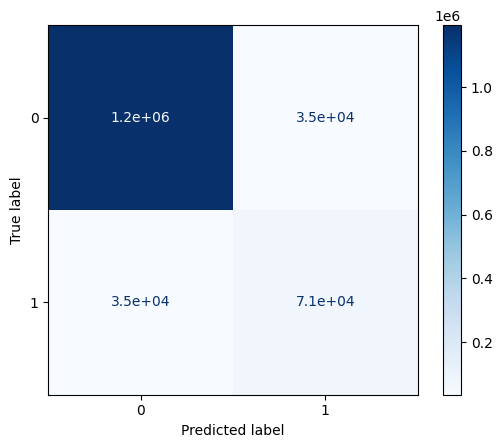

In [30]:
dropped_features = ["client_id","counter_number","invoice_date","counter_coefficient","consommation_level_1","consommation_level_2", "consommation_level_3", "consommation_level_4","target"]

# Defining target and features
y = df["target"]
X = df.drop(dropped_features, axis=1)

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RSEED)

# Initializing
tree = DecisionTreeClassifier()

# Fitting and predicting
tree.fit(X_train,y_train)
y_test_pred_tree = tree.predict(X_test)

# Evaluating on test
ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred_tree )).plot(cmap="Blues", values_format=".2g")
roc_auc_score(y_test,y_test_pred_tree), recall_score(y_test,y_test_pred_tree), recall_score(y_test,y_test_pred_tree, pos_label=0 )

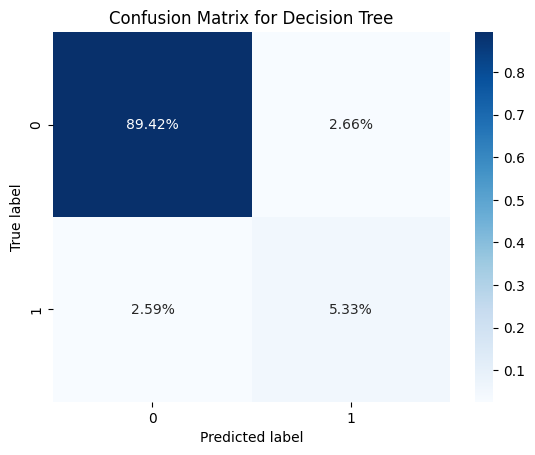

In [39]:
#cf_matrix = confusion_matrix(y_test,y_test_pred_tree )

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.title("Confusion Matrix for Decision Tree")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## KNN

In [ ]:
# Defining target and features
y = df["target"]
X = df.drop(["client_id","counter_number","invoice_date","target"], axis=1)

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RSEED)

# Initializing
knn = KNeighborsClassifier(n_neighbors=3, weights="distance", n_jobs=-1)

# Fitting and predicting
knn.fit(X_train,y_train)
y_test_pred_knn = knn.predict(X_test)

# Evaluating on test
ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred_knn )).plot(cmap="Blues")
roc_auc_score(y_test,y_test_pred_knn), f1_score(y_test,y_test_pred_knn), accuracy_score(y_test,y_test_pred_knn)

## Hyperparameter Tuning

In [ ]:
knn.get_params()


In [ ]:
# Defining target and features
y = df["target"]
X = df[["counter_number"]]

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RSEED)

# Defining parameter grid (as dictionary)
param_grid = {'n_neighbors': 3, #this actually defines the model you use
             'weights': 'distance'}

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(KNeighborsClassifier(), param_grid, scoring="accuracy",
                  cv=5, verbose=5, n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
gs.fit(X_train, y_train)

In [ ]:
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)